In [ ]:
import sys
import subprocess
# Check if pyspark is installed, if not, install it
try:
    import pyspark
    print("PySpark is already installed.")
except ImportError:
    print("PySpark not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyspark"])
    print("PySpark installed successfully.")

In [ ]:
!gdown --id 1mnHABJPgkjhfwPpYWwn5LONVg31A0WWh

In [1]:
# creat a session spark
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("test_session") \
    .getOrCreate() 

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/25 12:20:59 WARN Utils: Your hostname, mehdi, resolves to a loopback address: 127.0.1.1; using 10.0.0.157 instead (on interface wlxfc221c101da9)
25/10/25 12:20:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/25 12:21:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [16]:
df_heart = spark.read.csv('heart.csv', header=True, inferSchema=True, nanValue='Nan')


# Data checks & EDA

In [17]:
from pyspark.sql.functions import col, when

# Convert HeartDisease column from integer to boolean

df_heart = df_heart.withColumn(
    "HeartDisease", 
    when(col("HeartDisease") == 1, True).otherwise(False)
)


# Schema overview
df_heart.printSchema()

# Count rows and columns
n_rows = df_heart.count()
n_cols = len(df_heart.columns)
print(f"Dataset contains {n_rows} rows and {n_cols} columns")


root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: boolean (nullable = false)

Dataset contains 918 rows and 12 columns


- Missing Values Audit

In [18]:
from pyspark.sql import functions as F

# Split columns by dtype
numeric_cols  = [c for c, t in df_heart.dtypes if t in ("int", "double", "float", "bigint")]
string_cols   = [c for c, t in df_heart.dtypes if t == "string"]
boolean_cols  = [c for c, t in df_heart.dtypes if t in ("boolean", "bool")]

n_rows = df_heart.count()

# Missing for numeric: null or NaN
missing_numeric = df_heart.select([
    F.sum(F.when(F.col(c).isNull() | F.isnan(F.col(c)), 1).otherwise(0)).alias(c)
    for c in numeric_cols
])

# Missing for string: null, empty, or 'na'/'nan'
missing_string = df_heart.select([
    F.sum(
        F.when(
            F.col(c).isNull() |
            (F.trim(F.col(c)) == "") |
            (F.lower(F.trim(F.col(c))).isin("na", "nan")),
            1
        ).otherwise(0)
    ).alias(c)
    for c in string_cols
])

# Missing for boolean: only null
missing_boolean = df_heart.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in boolean_cols
])

print("=== Missing (numeric) ===")
missing_numeric.show(truncate=False)

print("=== Missing (string) ===")
missing_string.show(truncate=False)

print("=== Missing (boolean) ===")
missing_boolean.show(truncate=False)

# -------- Tidy combined report --------
rows = []

for c in numeric_cols:
    cnt = missing_numeric.select(c).first()[0]
    rows.append((c, "numeric", int(cnt), float(cnt)/n_rows))

for c in string_cols:
    cnt = missing_string.select(c).first()[0]
    rows.append((c, "string", int(cnt), float(cnt)/n_rows))

for c in boolean_cols:
    cnt = missing_boolean.select(c).first()[0]
    rows.append((c, "boolean", int(cnt), float(cnt)/n_rows))

report_df = spark.createDataFrame(rows, ["column", "dtype", "n_missing", "pct_missing"])
report_df.orderBy(F.desc("pct_missing"), F.asc("column")).show(truncate=False)


=== Missing (numeric) ===
+---+---------+-----------+---------+-----+-------+
|Age|RestingBP|Cholesterol|FastingBS|MaxHR|Oldpeak|
+---+---------+-----------+---------+-----+-------+
|0  |0        |0          |0        |0    |0      |
+---+---------+-----------+---------+-----+-------+

=== Missing (string) ===
+---+-------------+----------+--------------+--------+
|Sex|ChestPainType|RestingECG|ExerciseAngina|ST_Slope|
+---+-------------+----------+--------------+--------+
|0  |0            |0         |0             |0       |
+---+-------------+----------+--------------+--------+

=== Missing (boolean) ===
+------------+
|HeartDisease|
+------------+
|0           |
+------------+

+--------------+-------+---------+-----------+
|column        |dtype  |n_missing|pct_missing|
+--------------+-------+---------+-----------+
|Age           |numeric|0        |0.0        |
|ChestPainType |string |0        |0.0        |
|Cholesterol   |numeric|0        |0.0        |
|ExerciseAngina|string |0   

- Target Class Balance

In [19]:
from pyspark.sql import functions as F

balance = (
    df_heart.groupBy("HeartDisease")
    .count()
    .withColumn("Percentage", F.round((F.col("count") / n_rows) * 100, 2))
)
balance.show()


+------------+-----+----------+
|HeartDisease|count|Percentage|
+------------+-----+----------+
|        true|  508|     55.34|
|       false|  410|     44.66|
+------------+-----+----------+



- # Numeric Summary Statistics

In [ ]:
umeric_cols = [c for c, t in df_heart.dtypes if t in ("int", "double")]

df_heart.select(numeric_cols).describe().show(truncate=False)


25/10/25 12:29:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+-------------------+------------------+------------------+
|summary|Age               |RestingBP         |Cholesterol       |FastingBS          |MaxHR             |Oldpeak           |
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+
|count  |918               |918               |918               |918                |918               |918               |
|mean   |53.510893246187365|132.39651416122004|198.7995642701525 |0.23311546840958605|136.80936819172112|0.8873638344226581|
|stddev |9.43261650673202  |18.514154119907808|109.38414455220345|0.42304562473930296|25.46033413825029 |1.0665701510493264|
|min    |28                |0                 |0                 |0                  |60                |-2.6              |
|max    |77                |200               |603               |1                  |202               |6.2               |


- Invalid physiological ranges

In [ ]:
invalid_bp   = df_heart.filter(F.col("RestingBP") <= 0).count()
invalid_chol = df_heart.filter(F.col("Cholesterol") <= 0).count()

print(f"Invalid RestingBP values: {invalid_bp}")
print(f"Invalid Cholesterol values: {invalid_chol}")

# Quick range checks
df_heart.selectExpr(
    "min(Age) as min_Age", "max(Age) as max_Age",
    "min(MaxHR) as min_MaxHR", "max(MaxHR) as max_MaxHR",
    "min(Oldpeak) as min_Oldpeak", "max(Oldpeak) as max_Oldpeak"
).show()


Invalid RestingBP values: 1
Invalid Cholesterol values: 172
+-------+-------+---------+---------+-----------+-----------+
|min_Age|max_Age|min_MaxHR|max_MaxHR|min_Oldpeak|max_Oldpeak|
+-------+-------+---------+---------+-----------+-----------+
|     28|     77|       60|      202|       -2.6|        6.2|
+-------+-------+---------+---------+-----------+-----------+



- Correlation analysis


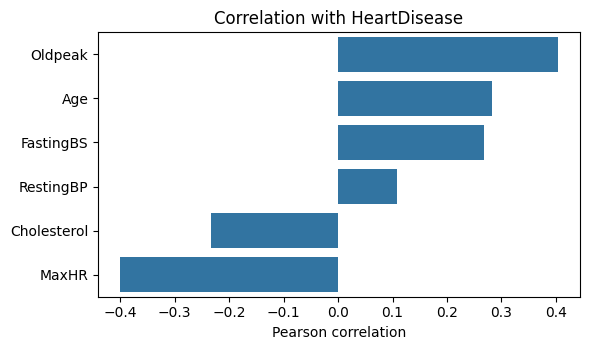

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Numeric label
df_e = df_heart.withColumn("label", F.col("HeartDisease").cast("int"))

# Pick numeric features + label
cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak", "FastingBS", "label"]

# To pandas
pdf = df_e.select(cols).toPandas()

# Correlations with label only
corr_with_label = (
    pdf.corr()[["label"]]
       .drop(index="label")                # drop label–label
       .rename(columns={"label":"corr"})   # nicer name
       .sort_values("corr", ascending=False)
)

# Using corr_with_label from above
corr_with_label["feature"] = corr_with_label.index

plt.figure(figsize=(6, 3.6))
sns.barplot(data=corr_with_label, x="corr", y="feature", orient="h")
plt.title("Correlation with HeartDisease")
plt.xlabel("Pearson correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()


- Full correlation matrix

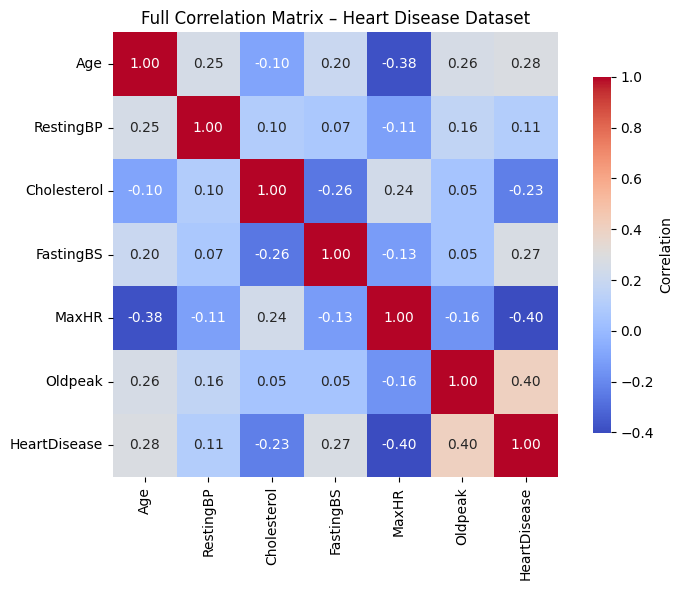

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Add numeric label for correlations
df_e = df_heart.withColumn("HeartDisease", F.col("HeartDisease").cast("int"))

# Select only numeric columns (including HeartDisease)
numeric_cols = ["Age", "RestingBP", "Cholesterol", "FastingBS",
                "MaxHR", "Oldpeak", "HeartDisease"]

# Convert to pandas for plotting
pdf = df_e.select(numeric_cols).toPandas()

# Compute correlation matrix
corr_matrix = pdf.corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f",
    cmap="coolwarm", square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)
plt.title("Full Correlation Matrix – Heart Disease Dataset")
plt.tight_layout()
plt.show()


- Target Class Balance

In [ ]:
# 
from pyspark.sql import functions as F

total = df_e.count()
balance = (
    df_e.groupBy("label").count()
        .withColumn("pct", F.round(F.col("count")/F.lit(total), 3))
        .orderBy("label")
)
balance.show()


+-----+-----+-----+
|label|count|  pct|
+-----+-----+-----+
|    0|  410|0.447|
|    1|  508|0.553|
+-----+-----+-----+



In [ ]:
# 
num_cols = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak","FastingBS"]

stats = []
for c in num_cols:
    s = (df_e.groupBy("label")
            .agg(
                F.round(F.mean(c),2).alias(f"{c}_mean"),
                F.round(F.stddev(c),2).alias(f"{c}_std"),
                F.expr(f"percentile_approx({c}, 0.5)").alias(f"{c}_median"),
                F.expr(f"percentile_approx({c}, 0.1)").alias(f"{c}_p10"),
                F.expr(f"percentile_approx({c}, 0.9)").alias(f"{c}_p90"),
            ))
    print(f"--- {c} ---")
    s.show()


--- Age ---
+-----+--------+-------+----------+-------+-------+
|label|Age_mean|Age_std|Age_median|Age_p10|Age_p90|
+-----+--------+-------+----------+-------+-------+
|    1|    55.9|   8.73|        57|     43|     66|
|    0|   50.55|   9.44|        51|     38|     63|
+-----+--------+-------+----------+-------+-------+

--- RestingBP ---
+-----+--------------+-------------+----------------+-------------+-------------+
|label|RestingBP_mean|RestingBP_std|RestingBP_median|RestingBP_p10|RestingBP_p90|
+-----+--------------+-------------+----------------+-------------+-------------+
|    1|        134.19|        19.83|             132|          110|          160|
|    0|        130.18|         16.5|             130|          110|          150|
+-----+--------------+-------------+----------------+-------------+-------------+

--- Cholesterol ---
+-----+----------------+---------------+------------------+---------------+---------------+
|label|Cholesterol_mean|Cholesterol_std|Cholesterol_

In [33]:
df_e.crosstab("Sex", "label").show()            # Sex vs HeartDisease
df_e.crosstab("ChestPainType", "label").show()  # ChestPainType vs HeartDisease


+---------+---+---+
|Sex_label|  0|  1|
+---------+---+---+
|        F|143| 50|
|        M|267|458|
+---------+---+---+

+-------------------+---+---+
|ChestPainType_label|  0|  1|
+-------------------+---+---+
|                NAP|131| 72|
|                ATA|149| 24|
|                 TA| 26| 20|
|                ASY|104|392|
+-------------------+---+---+



- Distribution Visualization

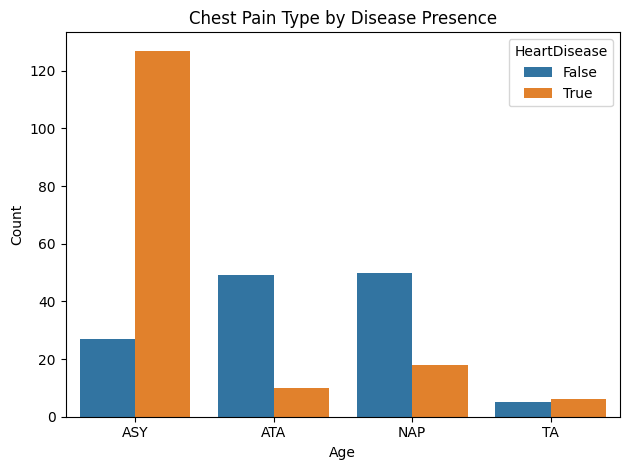

In [ ]:
# 
pdf = df_heart.sample(fraction=0.3, seed=42).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

# Histogram for Age
sns.histplot(pdf, x="Age", hue="HeartDisease", bins=20, kde=True)
plt.title("Age Distribution by Heart Disease")

# MaxHR
sns.histplot(pdf, x="MaxHR", hue="HeartDisease", bins=20, kde=True)
plt.title("Maximum Heart Rate vs Disease")

# Chest Pain Types
sns.countplot(data=pdf, x="ChestPainType", hue="HeartDisease")
plt.title("Chest Pain Type by Disease Presence")

plt.tight_layout()
plt.show()


# Feature engineering

- Identify Feature Types

In [45]:
# Numerical and categorical features
numeric_cols = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

label_col = "HeartDisease"


- Encode Categorical Variables

In [46]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Index categorical columns
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="keep")
    for c in categorical_cols
]

# One-hot encode indexed columns
encoders = [
    OneHotEncoder(inputCols=[c + "_index"], outputCols=[c + "_vec"])
    for c in categorical_cols
]


- Scale Numerical Columns

In [48]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Assemble numeric columns
assembler_num = VectorAssembler(inputCols=numeric_cols, outputCol="num_features")

# Scale them
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_features", withMean=True, withStd=True)


- Assemble Final Feature Vector

In [49]:
# Collect all feature columns
encoded_vecs = [c + "_vec" for c in categorical_cols]

assembler_all = VectorAssembler(
    inputCols=["scaled_features"] + encoded_vecs,
    outputCol="features"
)


- Build Full Feature Engineering Pipeline

In [50]:
from pyspark.ml import Pipeline

stages = indexers + encoders + [assembler_num, scaler, assembler_all]
pipeline = Pipeline(stages=stages)

# Fit + transform the dataset
df_prepared = pipeline.fit(df_heart).transform(df_heart)

# Verify
df_prepared.select("features", "HeartDisease").show(3, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                    |HeartDisease|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|(20,[0,1,2,3,4,5,6,10,12,15,18],[-1.4323590105189428,0.41068502452423855,0.8246207537583257,-0.551040962906166,1.382174782828565,-0.8319788750413103,1.0,1.0,1.0,1.0,1.0])  |false       |
|(20,[0,1,2,3,4,5,7,9,12,15,17],[-0.4782229027298965,1.490939616252763,-0.17186736109802728,-0.551040962906166,0.7537462668036152,0.10560596081422916,1.0,1.0,1.0,1.0,1.0])  |true        |
|(20,[0,1,2,3,4,5,6,10,14,15,18],[-1.7504043797819582,-0.129

- Split Data

In [52]:
train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)
print(f"Train size: {train_df.count()} | Test size: {test_df.count()}")


Train size: 769 | Test size: 149


# Logistic Regression (Baseline)

In [53]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize model
lr = LogisticRegression(
    labelCol="HeartDisease",
    featuresCol="features",
    elasticNetParam=0.5,   # 0=L2, 1=L1
    regParam=0.05,
    maxIter=100
)

# Train
lr_model = lr.fit(train_df)

# Evaluate
pred_lr = lr_model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")
roc_lr = evaluator.evaluate(pred_lr)
print(f"Logistic Regression AUC = {roc_lr:.3f}")


IllegalArgumentException: requirement failed: Column HeartDisease must be of type numeric but was actually of type boolean.